<h1><center></center></h1>
<div style="display: flex; justify-content: center; margin: 0 auto;" align="center">
  <img src="https://myth-ai.com/wp-content/uploads/2023/05/646f153be1e56.png" href="https://myth-ai.com/" width="100px" align="center">
  <h1>Technical Assignment</h1>
</div>

<div align="center">
  <h2>
  Sketch Generation via Diffusion Models using Sequential Strokes
  </h2>
</div>


<div align="center">
  <img src="https://github.com/googlecreativelab/quickdraw-dataset/blob/master/preview.jpg?raw=true">
  <figcaption>
    Collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. Drawings were captured as timestamped vectors.
    <i>Source: <a href="https://quickdraw.withgoogle.com/data/">Quick, Draw! Dataset</a>.</i>
  </figcaption>
</div>

---

## Objective

In this project, you are expected to implement a **conditional generative diffusion model** that learns to generate hand-drawn sketches in a **stroke-by-stroke** sequential manner. Rather than generating the entire sketch at once, your model should mimic the **sequential nature of human drawing**, producing strokes one after another in a realistic and interpretable way.

You will use the [Quick, Draw!](https://quickdraw.withgoogle.com/data/) dataset released by Google, which provides timestamped vector representations of user-drawn sketches across 345 object categories.

---

## Brief Explanation

You will design and train a **separate conditional diffusion model** for each of the following three categories:

- `cat`
- `bus`
- `rabbit`

Each model must learn to generate sketches from that category using **sequential stroke data**. That means you will build **three separate models** in total—one per category.

Your implementation must be documented in a reproducible Jupyter notebook, including training steps, visualizations, and both qualitative and quantitative evaluations.

- Include comprehensive documentation of your approach and design decisions.
- Provide clear training procedures, model architecture explanations, and inference code.
- Ensure full reproducibility (running all cells should yield consistent results with fixed random seeds).

---

## Data Specification

The Quick, Draw! dataset includes over 50 million sketches in vector format, with each sketch consisting of multiple strokes, where each stroke is a sequence of coordinates (`x`, `y`) along with timing information.

You can download the raw `.ndjson` files from the this [section](#cell-id1). The following commands will download the required categories (`cat`, `bus`, `rabbit`) into the ./data directory.

**⚠️ Note:** If you're not using Google Colab or Kaggle, make sure you have `gsutil` installed. You can install it via pip:

```bash
pip install gsutil
```

**⚠️ Important:** The dataset files are in [NDJSON](https://github.com/ndjson/ndjson-spec) format. Make sure to install the ndjson Python module before attempting to parse the files.

```bash
pip install ndjson
```

### Train/Test Subsets for Target Categories

After downloading the dataset in the `./data` directory, extract the provided `subset.zip` file. This archive includes the predefined train/test splits for each of the three categories.

```
subset/
├── cat/
│  └── indices.json
├── bus/
│  └── indices.json
└── rabbit/
│  └── indices.json
```

Each `indices` file contains a JSON structure with two keys:

- `"train"`: list of indices for training
- `"test"`: list of indices for testing

**⚠️ Important:** Strictly adhere to these predefined splits for consistent evaluation.


---


## Evaluation

You must evaluate your model both **qualitatively** and **quantitatively**.

### Quantitative Evaluation

Use the following metrics to compare the real test set sketches with those generated by your model:

- **FID (Fréchet Inception Distance)**
- **KID (Kernel Inception Distance)**

These metrics should be computed **separately for each category** using the sketches indexed under the `"test"` key in each category’s `indices.json` file.

> **Final submission must include three FID and three KID scores—one pair per category.**

### Qualitative Evaluation

Provide visual demonstrations including:

- Sample generated sketches for each category.
- Your submission must include three animated GIFs (one per category) showing the stroke-by-stroke generation process, similar to `example.gif` file in the link.
- Comparison between real and generated sketches.


---


## Deliverables

Your submission should include the following:

- A well-structured **Jupyter Notebook** that:
  - Explains your approach and design decisions
  - Implements the conditional diffusion model
  - Includes training procedure and inference pipeline code
  - Presents both qualitative and quantitative results
  - Visual examples of generated sketches for each of the 3 categories
  - Animated GIFs demonstrating progressive sketch generation (similar to the provided example.gif)
  - Clearly computed FID/KID scores for each category
- Model performance analysis across categories
- Comparison of generated vs. real sketch characteristics
- Discussion of limitations and potential improvements


> 🔒 All visualizations must be based on sketches generated by your own model. Using samples from external sources will be considered **plagiarism** and will result in disqualification.

> 🔁 The notebook must be **fully reproducible**: running all cells from top to bottom should produce the same results (assuming fixed random seed).

---

## Acknowledgements

- [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset)
- [Quick, Draw! Kaggle Competition](https://www.kaggle.com/c/quickdraw-doodle-recognition/overview)
- [Diffusion Models Overview (Lil’Log)](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
- [Ha, D., & Eck, D. (2017). A neural representation of sketch drawings. arXiv preprint arXiv:1704.03477.](https://arxiv.org/pdf/1704.03477)
- Special thanks to M. Sung, KAIST

# Download the Quick, Draw! Dataset

<a name="cell-id1"></a>

In [4]:
# If you're not using Colab or Kaggle, uncomment the following line:
!pip install gsutil

In [5]:
%pip install ndjson

Note: you may need to restart the kernel to use updated packages.


In [6]:
%mkdir data
!gsutil -m cp 'gs://quickdraw_dataset/full/simplified/cat.ndjson' ./data
!gsutil -m cp 'gs://quickdraw_dataset/full/simplified/bus.ndjson' ./data
!gsutil -m cp 'gs://quickdraw_dataset/full/simplified/rabbit.ndjson' ./data

A subdirectory or file data already exists.
InvalidUrlError: Unrecognized scheme "'gs".
InvalidUrlError: Unrecognized scheme "'gs".
InvalidUrlError: Unrecognized scheme "'gs".


# Solution

- Briefly explain why you chose the method you did.
- Discuss the drawbacks and advantages of your chosen method.
- Evaluate and discuss the results for each metric.

# Section 1: Data Loading and Preprocessing

## Imports and Setup

In [7]:
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

In [8]:
# Load raw sketches
with open("./data/cat.ndjson", 'r') as f:
    cat_sketches = [json.loads(line) for line in f]

# Load train/test indices
with open("./subset/cat/indices.json", 'r') as f:
    cat_indices = json.load(f)

cat_train = [cat_sketches[i] for i in cat_indices["train"]]
cat_test = [cat_sketches[i] for i in cat_indices["test"]]

len(cat_train), len(cat_test)

(10000, 2000)

In [9]:
# Take first training sketch
sketch = cat_train[0]
drawing = sketch["drawing"]

# Collect all points for normalization
all_points = []
for stroke in drawing:
    points = list(zip(stroke[0], stroke[1]))
    all_points.extend(points)

# Normalize to [-1, 1]
all_x, all_y = zip(*all_points)
min_x, max_x = min(all_x), max(all_x)
min_y, max_y = min(all_y), max(all_y)
width = max_x - min_x if max_x > min_x else 1
height = max_y - min_y if max_y > min_y else 1

# Build sequence: [command, x, y]
# 0: draw, 1: pen_up, 2: pen_down, 3: end
sequence = []

for stroke in drawing:
    sequence.append([2, 0, 0])  # pen_down

    for x, y in zip(stroke[0], stroke[1]):
        norm_x = 2 * (x - min_x) / width - 1
        norm_y = 2 * (y - min_y) / height - 1
        sequence.append([0, norm_x, norm_y])  # draw

    sequence.append([1, 0, 0])  # pen_up

sequence.append([3, 0, 0])  # end
sequence = torch.tensor(sequence, dtype=torch.float32)
sequence.shape

torch.Size([108, 3])

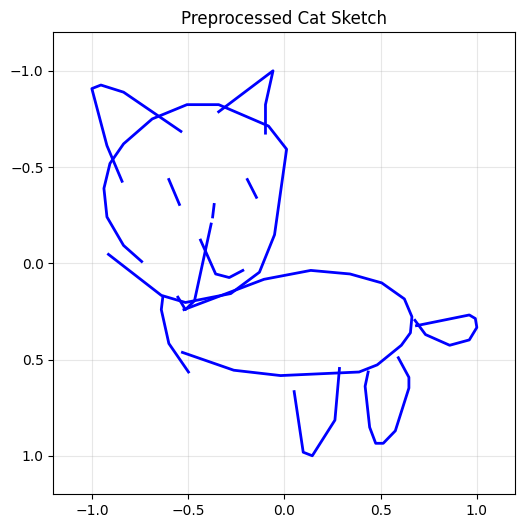

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

current_stroke = []
pen_down = False

for command, x, y in sequence:
    if command == 2:  # pen_down
        pen_down = True
        current_stroke = []
    elif command == 1:  # pen_up
        if pen_down and len(current_stroke) > 1:
            xs, ys = zip(*current_stroke)
            ax.plot(xs, ys, 'b-', linewidth=2)
        pen_down = False
    elif command == 0 and pen_down:  # draw
        current_stroke.append([x, y])
    elif command == 3:  # end
        break

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_title("Preprocessed Cat Sketch")
ax.grid(True, alpha=0.3)
plt.show()

In [11]:
cat_sequences = []
max_length = 200

for sketch in cat_train:
    drawing = sketch["drawing"]

    # Collect and normalize points
    all_points = []
    for stroke in drawing:
        all_points.extend(zip(stroke[0], stroke[1]))

    if not all_points:
        continue

    all_x, all_y = zip(*all_points)
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    width = max_x - min_x if max_x > min_x else 1
    height = max_y - min_y if max_y > min_y else 1

    # Build sequence
    sequence = []
    for stroke in drawing:
        sequence.append([2, 0, 0])
        for x, y in zip(stroke[0], stroke[1]):
            norm_x = 2 * (x - min_x) / width - 1
            norm_y = 2 * (y - min_y) / height - 1
            sequence.append([0, norm_x, norm_y])
        sequence.append([1, 0, 0])
    sequence.append([3, 0, 0])

    # Pad or truncate
    sequence = torch.tensor(sequence, dtype=torch.float32)
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        padding = torch.tensor([[3, 0, 0]] * (max_length - len(sequence)))
        sequence = torch.cat([sequence, padding])

    cat_sequences.append(sequence)

len(cat_sequences)

10000

In [12]:
class SimpleDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

cat_dataset = SimpleDataset(cat_sequences)
cat_loader = DataLoader(cat_dataset, batch_size=32, shuffle=True)

# Test batch
batch = next(iter(cat_loader))
batch.shape

torch.Size([32, 200, 3])

# Section 2: Data Analysis and Visualization

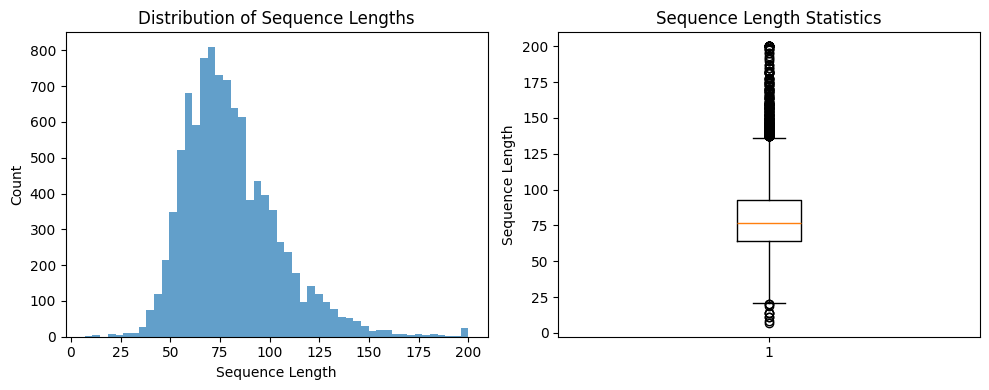

'Min: 7, Max: 200, Mean: 80.9'

In [13]:
# Check sequence lengths distribution
seq_lengths = [len(seq[seq[:, 0] != 3]) for seq in cat_sequences]  # Exclude padding
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(seq_lengths, bins=50, alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Sequence Lengths')

plt.subplot(1, 2, 2)
plt.boxplot(seq_lengths)
plt.ylabel('Sequence Length')
plt.title('Sequence Length Statistics')

plt.tight_layout()
plt.show()

f"Min: {min(seq_lengths)}, Max: {max(seq_lengths)}, Mean: {np.mean(seq_lengths):.1f}"

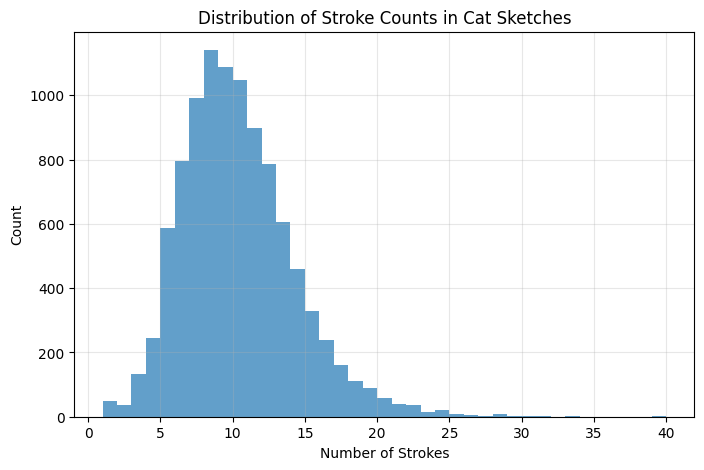

'Strokes per sketch - Min: 1, Max: 39, Mean: 9.9'

In [14]:
# Count strokes per sketch (pen_down commands)
stroke_counts = []
for seq in cat_sequences:
    pen_downs = (seq[:, 0] == 2).sum().item()
    stroke_counts.append(pen_downs)

plt.figure(figsize=(8, 5))
plt.hist(stroke_counts, bins=range(1, max(stroke_counts)+2), alpha=0.7)
plt.xlabel('Number of Strokes')
plt.ylabel('Count')
plt.title('Distribution of Stroke Counts in Cat Sketches')
plt.grid(True, alpha=0.3)
plt.show()

f"Strokes per sketch - Min: {min(stroke_counts)}, Max: {max(stroke_counts)}, Mean: {np.mean(stroke_counts):.1f}"

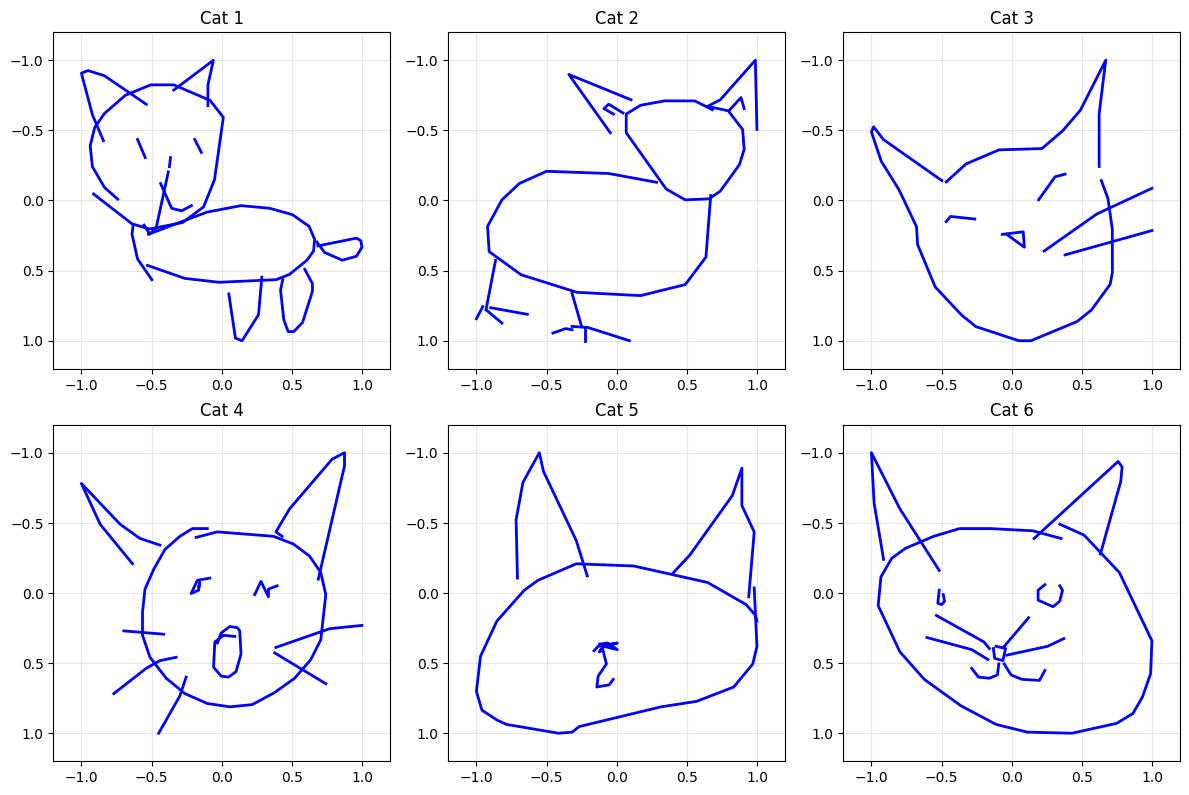

In [15]:
# Show 6 random cat sketches
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    seq = cat_sequences[i]

    current_stroke = []
    pen_down = False

    for command, x, y in seq:
        if command == 2:  # pen_down
            pen_down = True
            current_stroke = []
        elif command == 1:  # pen_up
            if pen_down and len(current_stroke) > 1:
                xs, ys = zip(*current_stroke)
                ax.plot(xs, ys, 'b-', linewidth=2)
            pen_down = False
        elif command == 0 and pen_down:  # draw
            current_stroke.append([x, y])
        elif command == 3:  # end
            break

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(f'Cat {i+1}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

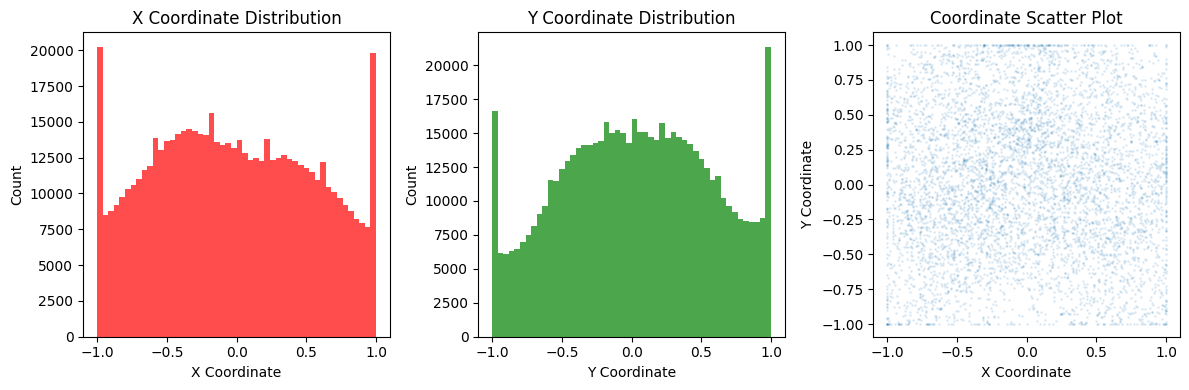

In [16]:
# Extract all drawing coordinates (command=0)
all_coords = []
for seq in cat_sequences:
    drawing_points = seq[seq[:, 0] == 0]  # Only drawing commands
    if len(drawing_points) > 0:
        all_coords.append(drawing_points[:, 1:])  # x, y coordinates

all_coords = torch.cat(all_coords)
x_coords = all_coords[:, 0].numpy()
y_coords = all_coords[:, 1].numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(x_coords, bins=50, alpha=0.7, color='red')
plt.xlabel('X Coordinate')
plt.ylabel('Count')
plt.title('X Coordinate Distribution')

plt.subplot(1, 3, 2)
plt.hist(y_coords, bins=50, alpha=0.7, color='green')
plt.xlabel('Y Coordinate')
plt.ylabel('Count')
plt.title('Y Coordinate Distribution')

plt.subplot(1, 3, 3)
plt.scatter(x_coords[::100], y_coords[::100], alpha=0.1, s=1)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Coordinate Scatter Plot')
plt.axis('equal')

plt.tight_layout()
plt.show()

In [17]:
# Load bus and rabbit data
categories = ['bus', 'rabbit']
all_data = {'cat': cat_sequences}

for category in categories:
    # Load sketches
    with open(f"./data/{category}.ndjson", 'r') as f:
        sketches = [json.loads(line) for line in f]

    with open(f"./subset/{category}/indices.json", 'r') as f:
        indices = json.load(f)

    train_sketches = [sketches[i] for i in indices["train"]]

    # Process sequences
    sequences = []
    for sketch in train_sketches:
        drawing = sketch["drawing"]

        all_points = []
        for stroke in drawing:
            all_points.extend(zip(stroke[0], stroke[1]))

        if not all_points:
            continue

        all_x, all_y = zip(*all_points)
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)
        width = max_x - min_x if max_x > min_x else 1
        height = max_y - min_y if max_y > min_y else 1

        sequence = []
        for stroke in drawing:
            sequence.append([2, 0, 0])
            for x, y in zip(stroke[0], stroke[1]):
                norm_x = 2 * (x - min_x) / width - 1
                norm_y = 2 * (y - min_y) / height - 1
                sequence.append([0, norm_x, norm_y])
            sequence.append([1, 0, 0])
        sequence.append([3, 0, 0])

        sequence = torch.tensor(sequence, dtype=torch.float32)
        if len(sequence) > 200:
            sequence = sequence[:200]
        else:
            padding = torch.tensor([[3, 0, 0]] * (200 - len(sequence)))
            sequence = torch.cat([sequence, padding])

        sequences.append(sequence)

    all_data[category] = sequences

{k: len(v) for k, v in all_data.items()}

{'cat': 10000, 'bus': 10000, 'rabbit': 10000}

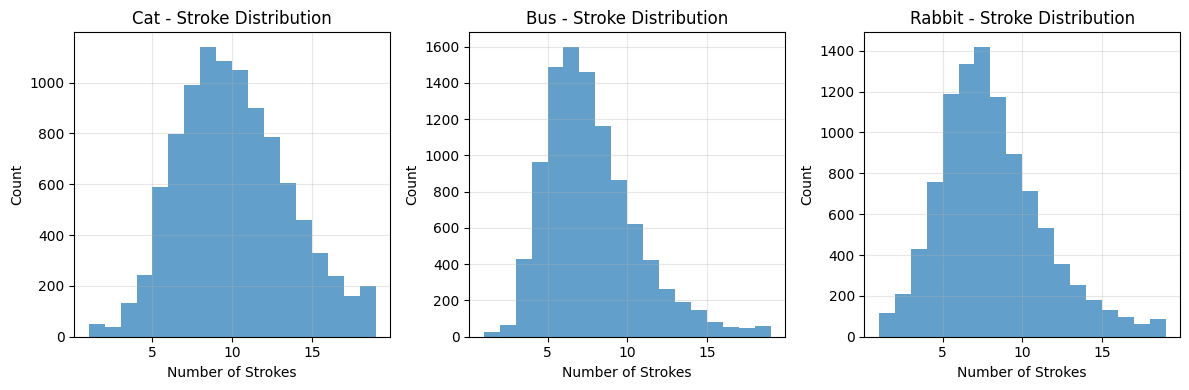

In [18]:
# Compare stroke counts across categories
plt.figure(figsize=(12, 4))

for i, (category, sequences) in enumerate(all_data.items()):
    stroke_counts = []
    for seq in sequences:
        pen_downs = (seq[:, 0] == 2).sum().item()
        stroke_counts.append(pen_downs)

    plt.subplot(1, 3, i+1)
    plt.hist(stroke_counts, bins=range(1, 20), alpha=0.7)
    plt.xlabel('Number of Strokes')
    plt.ylabel('Count')
    plt.title(f'{category.capitalize()} - Stroke Distribution')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

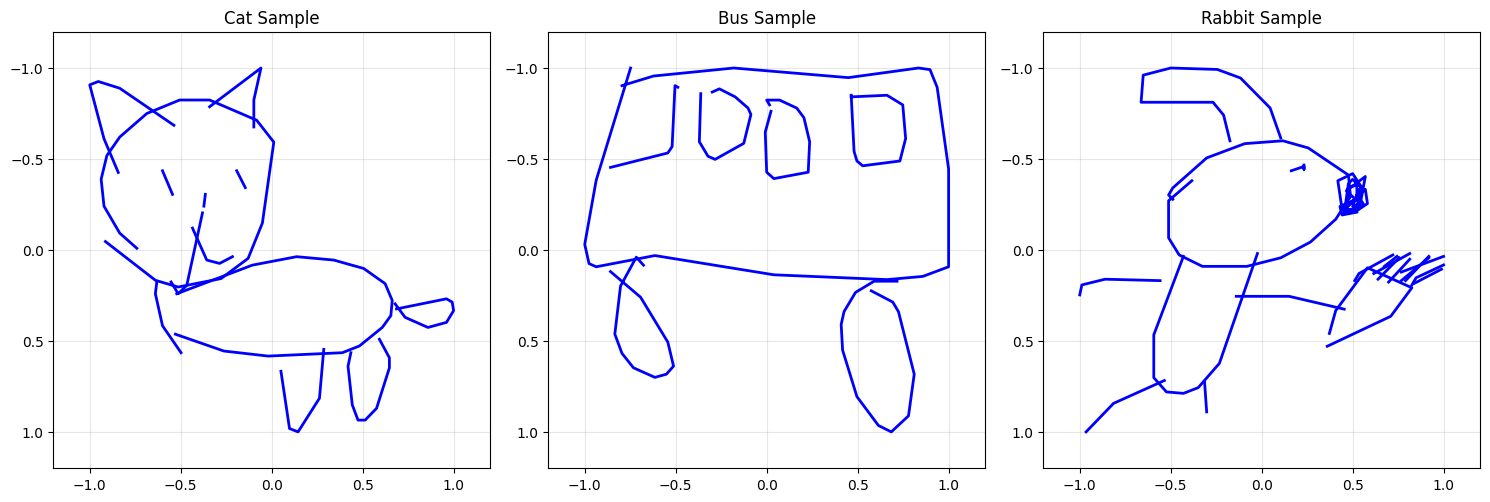

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (category, sequences) in enumerate(all_data.items()):
    seq = sequences[0]
    ax = axes[i]

    current_stroke = []
    pen_down = False

    for command, x, y in seq:
        if command == 2:  # pen_down
            pen_down = True
            current_stroke = []
        elif command == 1:  # pen_up
            if pen_down and len(current_stroke) > 1:
                xs, ys = zip(*current_stroke)
                ax.plot(xs, ys, 'b-', linewidth=2)
            pen_down = False
        elif command == 0 and pen_down:  # draw
            current_stroke.append([x, y])
        elif command == 3:  # end
            break

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(f'{category.capitalize()} Sample')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Create summary table
summary = {}
for category, sequences in all_data.items():
    seq_lengths = [len(seq[seq[:, 0] != 3]) for seq in sequences]
    stroke_counts = [(seq[:, 0] == 2).sum().item() for seq in sequences]

    summary[category] = {
        'count': len(sequences),
        'avg_length': np.mean(seq_lengths),
        'avg_strokes': np.mean(stroke_counts),
        'max_length': max(seq_lengths),
        'max_strokes': max(stroke_counts)
    }

import pandas as pd
pd.DataFrame(summary).T.round(2)

,count,avg_length,avg_strokes,max_length,max_strokes
cat,10000.0,80.86,9.89,200.0,39.0
bus,10000.0,74.94,7.35,200.0,37.0
rabbit,10000.0,80.34,7.70,200.0,30.0


# Section 3: Model Architecture Design

In [21]:
import torch.nn as nn
import torch.nn.functional as F
import math

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=200):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [23]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        # Ensure the output dimension matches exactly
        if embeddings.shape[-1] != self.dim:
            # Pad or truncate to match expected dimension
            if embeddings.shape[-1] < self.dim:
                padding = torch.zeros(embeddings.shape[0], self.dim - embeddings.shape[-1], device=device)
                embeddings = torch.cat([embeddings, padding], dim=-1)
            else:
                embeddings = embeddings[:, :self.dim]

        return embeddings

In [24]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, d_model * 4)
        self.linear2 = nn.Linear(d_model * 4, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self attention
        x2 = self.norm1(x)
        x2, _ = self.self_attn(x2, x2, x2, attn_mask=mask)
        x = x + self.dropout(x2)

        # Feed forward
        x2 = self.norm2(x)
        x2 = self.linear2(F.relu(self.linear1(x2)))
        x = x + self.dropout(x2)

        return x

In [25]:
class SketchDiffusionModel(nn.Module):
    def __init__(self, d_model=256, nhead=8, num_layers=6, seq_len=200):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len

        # Input projection: [command, x, y] -> d_model
        self.input_proj = nn.Linear(3, d_model)

        # Time embedding - ensure it matches d_model dimension
        self.time_embed = TimeEmbedding(d_model)
        self.time_proj = nn.Linear(d_model, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, seq_len)

        # Transformer layers
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, nhead) for _ in range(num_layers)
        ])

        # Output projection
        self.output_proj = nn.Linear(d_model, 3)

    def forward(self, x, t):
        # x: [batch, seq_len, 3]
        # t: [batch]

        batch_size, seq_len = x.shape[0], x.shape[1]

        # Input projection
        x = self.input_proj(x)  # [batch, seq_len, d_model]

        # Add time embedding
        t_emb = self.time_embed(t)  # [batch, d_model]
        t_emb = self.time_proj(t_emb)  # [batch, d_model]

        # Ensure proper broadcasting
        t_emb = t_emb.unsqueeze(1).expand(batch_size, seq_len, self.d_model)  # [batch, seq_len, d_model]

        # Add time embedding to input
        x = x + t_emb

        # Add positional encoding
        x = self.pos_encoding(x)

        # Transformer layers
        for layer in self.layers:
            x = layer(x)

        # Output projection
        x = self.output_proj(x)  # [batch, seq_len, 3]

        return x

In [26]:
# Create model instance
model = SketchDiffusionModel(d_model=256, nhead=8, num_layers=6)

# Test forward pass
batch_size = 4
seq_len = 200
x = torch.randn(batch_size, seq_len, 3)
t = torch.randint(0, 1000, (batch_size,))

output = model(x, t)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Input shape: torch.Size([4, 200, 3])
Output shape: torch.Size([4, 200, 3])
Model parameters: 4,806,147


In [39]:
class NoiseSchedule:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.num_timesteps = num_timesteps

        # Linear schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def to(self, device):
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alphas_cumprod = self.alphas_cumprod.to(device)
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(device)
        return self

noise_schedule = NoiseSchedule()

In [40]:
def forward_diffusion(x0, t, noise_schedule):
    """Forward diffusion process"""
    batch_size = x0.shape[0]
    device = x0.device

    # Ensure noise schedule is on the same device
    noise_schedule = noise_schedule.to(device)

    # Get noise schedule values
    sqrt_alphas_cumprod_t = noise_schedule.sqrt_alphas_cumprod[t]
    sqrt_one_minus_alphas_cumprod_t = noise_schedule.sqrt_one_minus_alphas_cumprod[t]

    # Reshape for broadcasting
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.view(batch_size, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.view(batch_size, 1, 1)

    # Sample noise
    noise = torch.randn_like(x0)

    # Apply noise
    x_t = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise

    return x_t, noise

In [41]:
# Test forward diffusion with cat data
sample_batch = torch.stack(cat_sequences[:8])  # Get 8 samples
timesteps = torch.randint(0, 1000, (8,))

# Add noise
noisy_batch, noise = forward_diffusion(sample_batch, timesteps, noise_schedule)

print(f"Original batch shape: {sample_batch.shape}")
print(f"Noisy batch shape: {noisy_batch.shape}")
print(f"Noise shape: {noise.shape}")
print(f"Timesteps: {timesteps}")

Original batch shape: torch.Size([8, 200, 3])
Noisy batch shape: torch.Size([8, 200, 3])
Noise shape: torch.Size([8, 200, 3])
Timesteps: tensor([990, 546, 515, 444, 831, 667, 529, 655])


In [42]:
def diffusion_loss(model, x0, noise_schedule, device):
    """Calculate diffusion loss"""
    batch_size = x0.shape[0]

    # Sample random timesteps
    t = torch.randint(0, noise_schedule.num_timesteps, (batch_size,), device=device)

    # Add noise
    x_t, noise = forward_diffusion(x0, t, noise_schedule)

    # Predict noise
    predicted_noise = model(x_t, t)

    # Calculate loss (MSE between actual and predicted noise)
    loss = nn.functional.mse_loss(predicted_noise, noise)

    return loss

In [43]:
# Move data to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
sample_batch = sample_batch.to(device)

# Calculate loss
loss = diffusion_loss(model, sample_batch, noise_schedule, device)
print(f"Loss: {loss.item():.4f}")
print(f"Using device: {device}")

Loss: 2.1076
Using device: cuda


# Section 4: Training Pipeline

In [44]:
import torch.optim as optim
from tqdm import tqdm
import os

# Training hyperparameters
learning_rate = 1e-4
num_epochs = 50
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cuda


In [45]:
def train_epoch(model, dataloader, optimizer, noise_schedule, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        batch = batch.to(device)

        # Calculate loss
        loss = diffusion_loss(model, batch, noise_schedule, device)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [46]:
# Create cat dataloader
cat_tensor = torch.stack(cat_sequences)
cat_dataset = SimpleDataset(cat_tensor)
cat_loader = DataLoader(cat_dataset, batch_size=batch_size, shuffle=True)

print(f"Cat dataset size: {len(cat_dataset)}")
print(f"Number of batches: {len(cat_loader)}")

Cat dataset size: 10000
Number of batches: 625


In [47]:
# Create and setup model for cats
cat_model = SketchDiffusionModel(d_model=256, nhead=8, num_layers=6).to(device)
cat_optimizer = optim.Adam(cat_model.parameters(), lr=learning_rate)

# Move noise schedule to device
noise_schedule.betas = noise_schedule.betas.to(device)
noise_schedule.alphas = noise_schedule.alphas.to(device)
noise_schedule.alphas_cumprod = noise_schedule.alphas_cumprod.to(device)
noise_schedule.alphas_cumprod_prev = noise_schedule.alphas_cumprod_prev.to(device)
noise_schedule.sqrt_alphas_cumprod = noise_schedule.sqrt_alphas_cumprod.to(device)
noise_schedule.sqrt_one_minus_alphas_cumprod = noise_schedule.sqrt_one_minus_alphas_cumprod.to(device)
noise_schedule.posterior_variance = noise_schedule.posterior_variance.to(device)

print(f"Cat model parameters: {sum(p.numel() for p in cat_model.parameters()):,}")

Cat model parameters: 4,806,147


Training: 100%|██████████| 625/625 [00:47<00:00, 13.28it/s]


Epoch 10/50, Loss: 0.0467


Training: 100%|██████████| 625/625 [00:47<00:00, 13.26it/s]


Epoch 20/50, Loss: 0.0396


Training: 100%|██████████| 625/625 [00:46<00:00, 13.30it/s]


Epoch 30/50, Loss: 0.0355


Training: 100%|██████████| 625/625 [00:46<00:00, 13.30it/s]


Epoch 40/50, Loss: 0.0318


Training: 100%|██████████| 625/625 [00:46<00:00, 13.30it/s]

Epoch 50/50, Loss: 0.0310


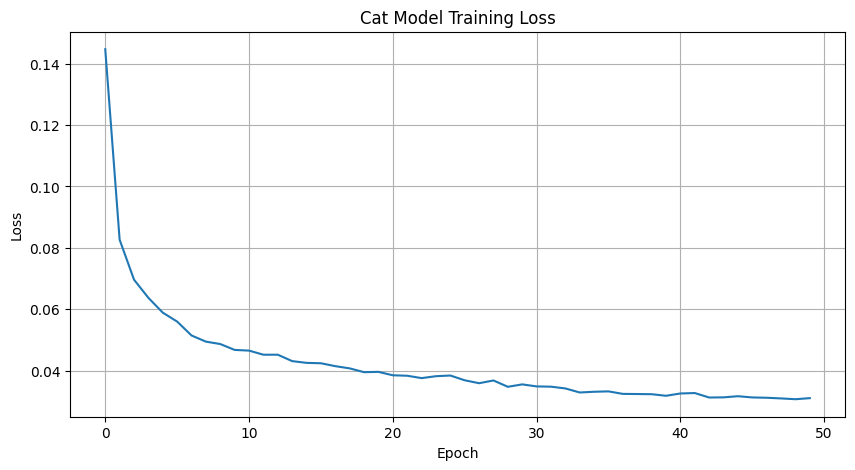

In [55]:
# Training loop for cats
cat_losses = []

for epoch in range(num_epochs):
    avg_loss = train_epoch(cat_model, cat_loader, cat_optimizer, noise_schedule, device)
    cat_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(cat_losses)
plt.title('Cat Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [56]:
# Create models directory
os.makedirs('./models', exist_ok=True)

# Save cat model
torch.save({
    'model_state_dict': cat_model.state_dict(),
    'optimizer_state_dict': cat_optimizer.state_dict(),
    'loss_history': cat_losses,
    'epoch': num_epochs
}, './models/cat_model.pth')

print("Cat model saved successfully!")

Cat model saved successfully!


In [48]:
# Prepare bus data
bus_tensor = torch.stack(all_data['bus'])
bus_dataset = SimpleDataset(bus_tensor)
bus_loader = DataLoader(bus_dataset, batch_size=batch_size, shuffle=True)

# Initialize bus model
bus_model = SketchDiffusionModel(d_model=256, nhead=8, num_layers=6).to(device)
bus_optimizer = optim.Adam(bus_model.parameters(), lr=learning_rate)

print(f"Bus dataset size: {len(bus_dataset)}")

Bus dataset size: 10000


Training: 100%|██████████| 625/625 [00:49<00:00, 12.69it/s]


Epoch 10/50, Loss: 0.0458


Training: 100%|██████████| 625/625 [00:47<00:00, 13.14it/s]


Epoch 20/50, Loss: 0.0385


Training: 100%|██████████| 625/625 [00:47<00:00, 13.27it/s]


Epoch 30/50, Loss: 0.0348


Training: 100%|██████████| 625/625 [00:52<00:00, 11.87it/s]


Epoch 40/50, Loss: 0.0316


Training: 100%|██████████| 625/625 [00:47<00:00, 13.07it/s]


Epoch 50/50, Loss: 0.0304


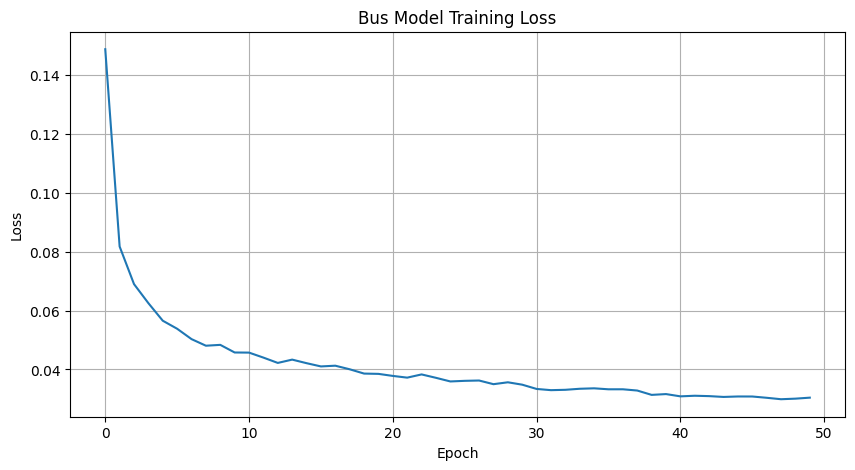

In [49]:
# Training loop for bus
bus_losses = []

for epoch in range(num_epochs):
    avg_loss = train_epoch(bus_model, bus_loader, bus_optimizer, noise_schedule, device)
    bus_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(bus_losses)
plt.title('Bus Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [50]:
# Save bus model
torch.save({
    'model_state_dict': bus_model.state_dict(),
    'optimizer_state_dict': bus_optimizer.state_dict(),
    'loss_history': bus_losses,
    'epoch': num_epochs
}, './models/bus_model.pth')

print("Bus model saved successfully!")

Bus model saved successfully!


In [51]:
# Prepare rabbit data
rabbit_tensor = torch.stack(all_data['rabbit'])
rabbit_dataset = SimpleDataset(rabbit_tensor)
rabbit_loader = DataLoader(rabbit_dataset, batch_size=batch_size, shuffle=True)

# Initialize rabbit model
rabbit_model = SketchDiffusionModel(d_model=256, nhead=8, num_layers=6).to(device)
rabbit_optimizer = optim.Adam(rabbit_model.parameters(), lr=learning_rate)

print(f"Rabbit dataset size: {len(rabbit_dataset)}")

Rabbit dataset size: 10000


Training: 100%|██████████| 625/625 [00:52<00:00, 11.85it/s]


Epoch 10/50, Loss: 0.0427


Training: 100%|██████████| 625/625 [00:47<00:00, 13.27it/s]


Epoch 20/50, Loss: 0.0376


Training: 100%|██████████| 625/625 [00:52<00:00, 11.97it/s]


Epoch 30/50, Loss: 0.0335


Training: 100%|██████████| 625/625 [00:50<00:00, 12.46it/s]


Epoch 40/50, Loss: 0.0313


Training: 100%|██████████| 625/625 [00:46<00:00, 13.30it/s]

Epoch 50/50, Loss: 0.0301


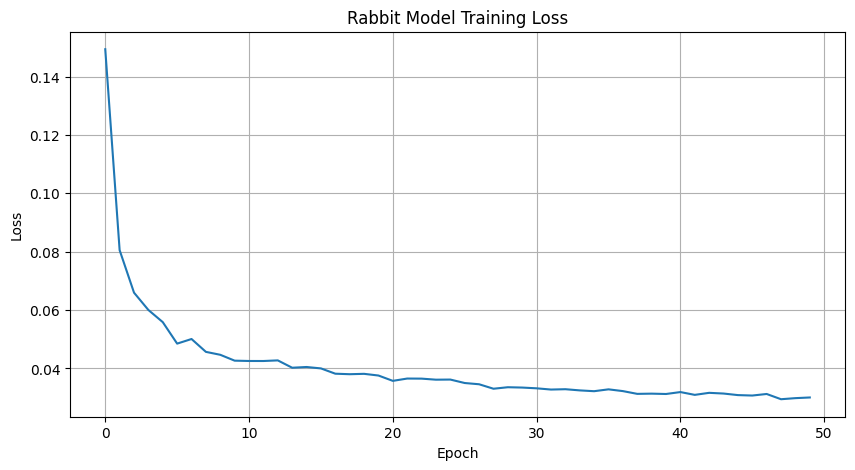

In [52]:
# Training loop for rabbit
rabbit_losses = []

for epoch in range(num_epochs):
    avg_loss = train_epoch(rabbit_model, rabbit_loader, rabbit_optimizer, noise_schedule, device)
    rabbit_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(rabbit_losses)
plt.title('Rabbit Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [53]:
# Save rabbit model
torch.save({
    'model_state_dict': rabbit_model.state_dict(),
    'optimizer_state_dict': rabbit_optimizer.state_dict(),
    'loss_history': rabbit_losses,
    'epoch': num_epochs
}, './models/rabbit_model.pth')

print("Rabbit model saved successfully!")

Rabbit model saved successfully!


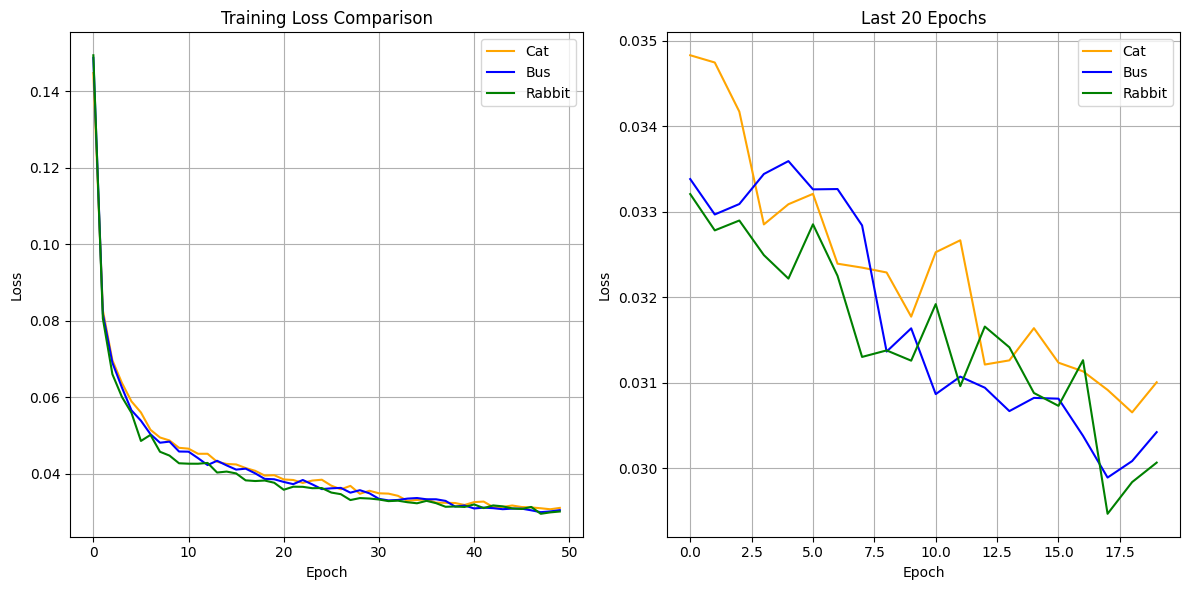

In [57]:
# Plot all training curves together
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cat_losses, label='Cat', color='orange')
plt.plot(bus_losses, label='Bus', color='blue')
plt.plot(rabbit_losses, label='Rabbit', color='green')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cat_losses[-20:], label='Cat', color='orange')
plt.plot(bus_losses[-20:], label='Bus', color='blue')
plt.plot(rabbit_losses[-20:], label='Rabbit', color='green')
plt.title('Last 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [58]:
# Print final training statistics
final_losses = {
    'cat': cat_losses[-1],
    'bus': bus_losses[-1],
    'rabbit': rabbit_losses[-1]
}

print("Final Training Losses:")
for category, loss in final_losses.items():
    print(f"  {category.capitalize()}: {loss:.4f}")

print(f"\nTotal training time: {num_epochs} epochs per model")
print("All models saved to ./models/ directory")

Final Training Losses:
  Cat: 0.0310
  Bus: 0.0304
  Rabbit: 0.0301

Total training time: 50 epochs per model
All models saved to ./models/ directory


# Section 5: Inference Pipeline

In [81]:
# Load all three models
models_list = {}
for category in ['cat', 'bus', 'rabbit']:
    model = SketchDiffusionModel(d_model=256, nhead=8, num_layers=6).to(device)
    checkpoint = torch.load(f'./models/{category}_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    models_list[category] = model

len(models_list)

3

In [82]:
@torch.no_grad()
def denoise_step(model, x_t, t, noise_schedule):
    """Single denoising step"""
    predicted_noise = model(x_t, t)

    alpha_t = noise_schedule.alphas[t].reshape(-1, 1, 1)
    alpha_cumprod_t = noise_schedule.alphas_cumprod[t].reshape(-1, 1, 1)
    beta_t = noise_schedule.betas[t].reshape(-1, 1, 1)

    if t[0] > 0:
        alpha_cumprod_prev = noise_schedule.alphas_cumprod[t-1].reshape(-1, 1, 1)
        posterior_mean = (
                (torch.sqrt(alpha_cumprod_prev) * beta_t) / (1 - alpha_cumprod_t) *
                (x_t - torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_t) +
                (torch.sqrt(alpha_t) * (1 - alpha_cumprod_prev)) / (1 - alpha_cumprod_t) * x_t
        )

        if t[0] > 1:
            posterior_variance = noise_schedule.posterior_variance[t].reshape(-1, 1, 1)
            noise = torch.randn_like(x_t)
            x_prev = posterior_mean + torch.sqrt(posterior_variance) * noise
        else:
            x_prev = posterior_mean
    else:
        x_prev = (x_t - torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_cumprod_t)

    return x_prev

In [83]:
@torch.no_grad()
def generate_sample(model, noise_schedule):
    """Generate one sketch from noise"""
    x = torch.randn(1, 200, 3, device=device)

    for t in reversed(range(noise_schedule.num_timesteps)):
        t_tensor = torch.tensor([t], device=device)
        x = denoise_step(model, x, t_tensor, noise_schedule)

    return x.squeeze(0).cpu()

In [84]:
def plot_sketch(sequence, title="Generated Sketch"):
    """Plot sequence as sketch"""
    plt.figure(figsize=(6, 6))

    current_stroke = []
    pen_down = False

    for command, x, y in sequence:
        if command >= 1.5:  # pen_down
            pen_down = True
            current_stroke = []
        elif -0.5 <= command <= 0.5 and pen_down:  # draw
            current_stroke.append([x.item(), y.item()])
        elif 0.5 <= command <= 1.5:  # pen_up
            if len(current_stroke) > 1:
                xs, ys = zip(*current_stroke)
                plt.plot(xs, ys, 'b-', linewidth=2)
            pen_down = False
        elif command >= 2.5:  # end
            break

    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.gca().set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

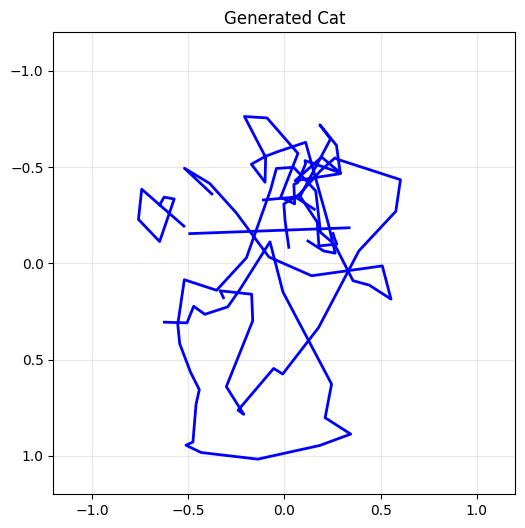

In [85]:
cat_sample = generate_sample(models_list['cat'], noise_schedule)
plot_sketch(cat_sample, "Generated Cat")

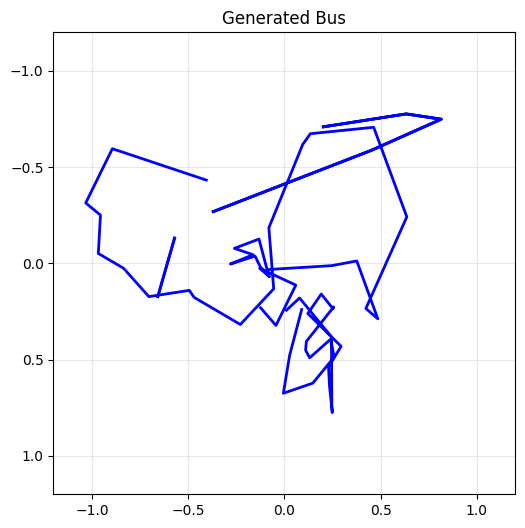

In [86]:
bus_sample = generate_sample(models_list['bus'], noise_schedule)
plot_sketch(bus_sample, "Generated Bus")

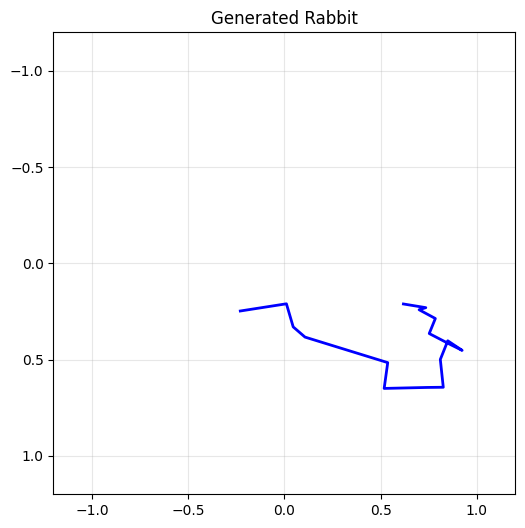

In [87]:
rabbit_sample = generate_sample(models_list['rabbit'], noise_schedule)
plot_sketch(rabbit_sample, "Generated Rabbit")

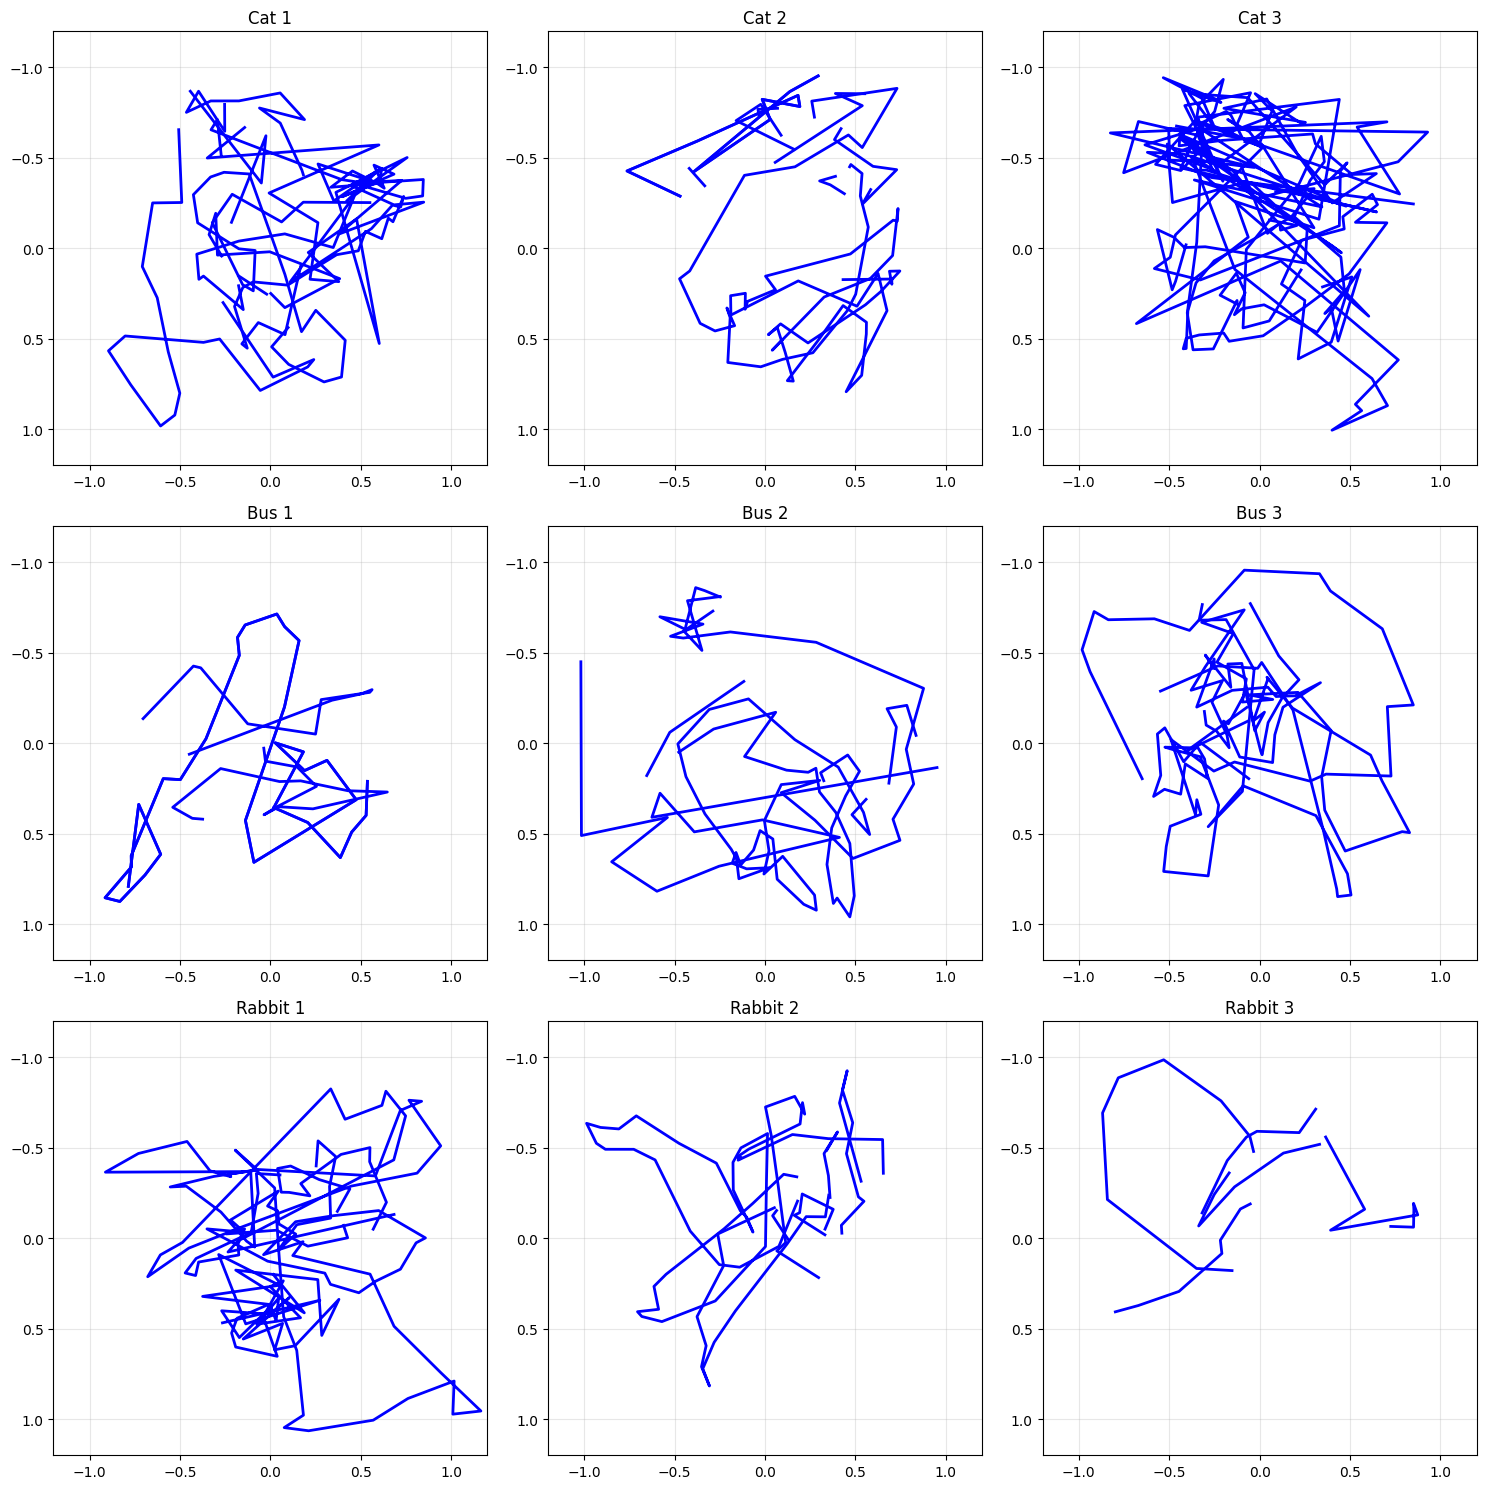

In [88]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, category in enumerate(['cat', 'bus', 'rabbit']):
    for j in range(3):
        sample = generate_sample(models_list[category], noise_schedule)
        ax = axes[i, j]

        current_stroke = []
        pen_down = False

        for command, x, y in sample:
            if command >= 1.5:
                pen_down = True
                current_stroke = []
            elif -0.5 <= command <= 0.5 and pen_down:
                current_stroke.append([x.item(), y.item()])
            elif 0.5 <= command <= 1.5:
                if len(current_stroke) > 1:
                    xs, ys = zip(*current_stroke)
                    ax.plot(xs, ys, 'b-', linewidth=2)
                pen_down = False
            elif command >= 2.5:
                break

        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_title(f'{category.capitalize()} {j+1}')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [89]:
def get_strokes(sequence):
    """Extract strokes from sequence"""
    strokes = []
    current_stroke = []
    pen_down = False

    for command, x, y in sequence:
        if command >= 1.5:  # pen_down
            pen_down = True
            current_stroke = []
        elif -0.5 <= command <= 0.5 and pen_down:  # draw
            current_stroke.append([x.item(), y.item()])
        elif 0.5 <= command <= 1.5:  # pen_up
            if len(current_stroke) > 1:
                strokes.append(current_stroke.copy())
            pen_down = False
        elif command >= 2.5:  # end
            break

    return strokes

In [90]:
import os
from PIL import Image

# Create animations directory
os.makedirs('./animations', exist_ok=True)

# Generate and save cat animation
cat_sample = generate_sample(models_list['cat'], noise_schedule)
cat_strokes = get_strokes(cat_sample)

frames = []
for i in range(len(cat_strokes) + 1):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw strokes up to current frame
    for j in range(i):
        if j < len(cat_strokes):
            xs, ys = zip(*cat_strokes[j])
            ax.plot(xs, ys, 'b-', linewidth=3)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(f'Cat - Stroke: {i}/{len(cat_strokes)}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Convert to image
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    # Convert RGBA to RGB by removing alpha channel
    frame = frame[:, :, :3]
    frames.append(Image.fromarray(frame))
    plt.close()


# Save GIF
frames[0].save('./animations/cat_generation.gif', save_all=True, append_images=frames[1:], duration=800, loop=0)
f"Cat GIF saved with {len(frames)} frames"

'Cat GIF saved with 6 frames'

In [91]:
# Generate and save bus animation
bus_sample = generate_sample(models_list['bus'], noise_schedule)
bus_strokes = get_strokes(bus_sample)

frames = []
for i in range(len(bus_strokes) + 1):
    fig, ax = plt.subplots(figsize=(6, 6))

    for j in range(i):
        if j < len(bus_strokes):
            xs, ys = zip(*bus_strokes[j])
            ax.plot(xs, ys, 'b-', linewidth=3)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(f'Bus - Stroke: {i}/{len(bus_strokes)}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = frame[:, :, :3]
    frames.append(Image.fromarray(frame))
    plt.close()

frames[0].save('./animations/bus_generation.gif', save_all=True, append_images=frames[1:], duration=800, loop=0)
f"Bus GIF saved with {len(frames)} frames"

'Bus GIF saved with 6 frames'

In [92]:
# Generate and save rabbit animation
rabbit_sample = generate_sample(models_list['rabbit'], noise_schedule)
rabbit_strokes = get_strokes(rabbit_sample)

frames = []
for i in range(len(rabbit_strokes) + 1):
    fig, ax = plt.subplots(figsize=(6, 6))

    for j in range(i):
        if j < len(rabbit_strokes):
            xs, ys = zip(*rabbit_strokes[j])
            ax.plot(xs, ys, 'b-', linewidth=3)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(f'Rabbit - Stroke: {i}/{len(rabbit_strokes)}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = frame[:, :, :3]
    frames.append(Image.fromarray(frame))
    plt.close()

frames[0].save('./animations/rabbit_generation.gif', save_all=True, append_images=frames[1:], duration=800, loop=0)
f"Rabbit GIF saved with {len(frames)} frames"

'Rabbit GIF saved with 6 frames'

# Section 6: Quantitative Evaluation

In [93]:
import subprocess
import sys

# Install required packages
try:
    import torchvision
    from scipy import linalg
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchvision", "scipy"])
    import torchvision
    from scipy import linalg

from torchvision import transforms
import torchvision.models as models

In [94]:
# Load test sketches for all categories
test_data = {}

for category in ['cat', 'bus', 'rabbit']:
    # Load raw sketches
    with open(f"./data/{category}.ndjson", 'r') as f:
        sketches = [json.loads(line) for line in f]

    # Load test indices
    with open(f"./subset/{category}/indices.json", 'r') as f:
        indices = json.load(f)

    test_sketches = [sketches[i] for i in indices["test"]]

    # Process test sequences
    sequences = []
    for sketch in test_sketches:
        drawing = sketch["drawing"]

        all_points = []
        for stroke in drawing:
            all_points.extend(zip(stroke[0], stroke[1]))

        if not all_points:
            continue

        all_x, all_y = zip(*all_points)
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)
        width = max_x - min_x if max_x > min_x else 1
        height = max_y - min_y if max_y > min_y else 1

        sequence = []
        for stroke in drawing:
            sequence.append([2, 0, 0])
            for x, y in zip(stroke[0], stroke[1]):
                norm_x = 2 * (x - min_x) / width - 1
                norm_y = 2 * (y - min_y) / height - 1
                sequence.append([0, norm_x, norm_y])
            sequence.append([1, 0, 0])
        sequence.append([3, 0, 0])

        sequence = torch.tensor(sequence, dtype=torch.float32)
        if len(sequence) > 200:
            sequence = sequence[:200]
        else:
            padding = torch.tensor([[3, 0, 0]] * (200 - len(sequence)))
            sequence = torch.cat([sequence, padding])

        sequences.append(sequence)

    test_data[category] = sequences

{k: len(v) for k, v in test_data.items()}

{'cat': 2000, 'bus': 2000, 'rabbit': 2000}

In [95]:
generated_data = {}

for category in ['cat', 'bus', 'rabbit']:
    num_samples = len(test_data[category])
    samples = []

    print(f"Generating {num_samples} samples for {category}...")
    for i in range(num_samples):
        sample = generate_sample(models_list[category], noise_schedule)
        samples.append(sample)

        if (i + 1) % 100 == 0:
            print(f"  Generated {i + 1}/{num_samples} samples")

    generated_data[category] = samples

{k: len(v) for k, v in generated_data.items()}

Generating 2000 samples for cat...
  Generated 100/2000 samples
  Generated 200/2000 samples


KeyboardInterrupt: 

In [96]:
def sequence_to_image(sequence, size=64):
    """Convert sequence to rasterized image"""
    # Create blank image
    img = np.ones((size, size, 3), dtype=np.uint8) * 255  # White background

    current_stroke = []
    pen_down = False

    for command, x, y in sequence:
        if command >= 1.5:  # pen_down
            pen_down = True
            current_stroke = []
        elif -0.5 <= command <= 0.5 and pen_down:  # draw
            # Convert normalized coords to image coords
            img_x = int((x + 1.2) / 2.4 * size)
            img_y = int((y + 1.2) / 2.4 * size)
            img_x = max(0, min(size-1, img_x))
            img_y = max(0, min(size-1, img_y))
            current_stroke.append([img_x, img_y])
        elif 0.5 <= command <= 1.5:  # pen_up
            # Draw the stroke
            if len(current_stroke) > 1:
                for i in range(len(current_stroke)-1):
                    x1, y1 = current_stroke[i]
                    x2, y2 = current_stroke[i+1]
                    # Simple line drawing
                    dx = abs(x2 - x1)
                    dy = abs(y2 - y1)
                    n_points = max(dx, dy, 1)
                    for j in range(n_points + 1):
                        t = j / n_points if n_points > 0 else 0
                        px = int(x1 + t * (x2 - x1))
                        py = int(y1 + t * (y2 - y1))
                        if 0 <= px < size and 0 <= py < size:
                            img[py, px] = [0, 0, 0]  # Black line
            pen_down = False
        elif command >= 2.5:  # end
            break

    return img

In [97]:
# Load pre-trained InceptionV3 for feature extraction
inception = models.inception_v3(pretrained=True, transform_input=False)
inception.fc = torch.nn.Identity()  # Remove final classification layer
inception.eval()
inception = inception.to(device)

# Image preprocessing
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

G:\Projects\exchance-environment\.venv\myth-case-study\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
G:\Projects\exchance-environment\.venv\myth-case-study\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\kiper/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:04<00:00, 25.1MB/s] 


In [98]:
@torch.no_grad()
def extract_features(images, model, batch_size=32):
    """Extract InceptionV3 features from images"""
    features = []

    for i in range(0, len(images), batch_size):
        batch_imgs = images[i:i+batch_size]

        # Preprocess batch
        batch_tensors = []
        for img in batch_imgs:
            tensor = preprocess(img)
            batch_tensors.append(tensor)

        batch_tensor = torch.stack(batch_tensors).to(device)

        # Extract features
        batch_features = model(batch_tensor)
        features.append(batch_features.cpu())

    return torch.cat(features, dim=0)

In [99]:
def calculate_fid(real_features, fake_features):
    """Calculate Fréchet Inception Distance"""
    # Convert to numpy
    real_features = real_features.numpy()
    fake_features = fake_features.numpy()

    # Calculate means and covariances
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if not np.isfinite(covmean).all():
        covmean = linalg.sqrtm((sigma1 + sigma2) / 2)

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return float(fid)

In [100]:
def calculate_kid(real_features, fake_features):
    """Calculate Kernel Inception Distance"""
    real_features = real_features.numpy()
    fake_features = fake_features.numpy()

    n = real_features.shape[0]
    m = fake_features.shape[0]

    # Polynomial kernel
    def polynomial_kernel(X, Y, degree=3, gamma=None, coef0=1):
        if gamma is None:
            gamma = 1.0 / X.shape[1]
        K = (gamma * np.dot(X, Y.T) + coef0) ** degree
        return K

    # Calculate kernel matrices
    Kxx = polynomial_kernel(real_features, real_features)
    Kxy = polynomial_kernel(real_features, fake_features)
    Kyy = polynomial_kernel(fake_features, fake_features)

    # Calculate KID
    kid = (Kxx.sum() / (n * n) + Kyy.sum() / (m * m) - 2 * Kxy.sum() / (n * m))
    return float(kid)

In [108]:
import scipy.linalg

def calculate_fid(real_features, fake_features):
    """Calculate Fréchet Inception Distance"""
    # Features are already numpy arrays
    if hasattr(real_features, 'numpy'):
        real_features = real_features.numpy()
    if hasattr(fake_features, 'numpy'):
        fake_features = fake_features.numpy()

    # Calculate means and covariances
    mu_real = np.mean(real_features, axis=0)
    mu_fake = np.mean(fake_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_fake = np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake
    covmean = scipy.linalg.sqrtm(sigma_real.dot(sigma_fake))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

def calculate_kid(real_features, fake_features):
    """Calculate Kernel Inception Distance"""
    # Features are already numpy arrays
    if hasattr(real_features, 'numpy'):
        real_features = real_features.numpy()
    if hasattr(fake_features, 'numpy'):
        fake_features = fake_features.numpy()

    # Normalize features
    real_features = real_features / np.linalg.norm(real_features, axis=1, keepdims=True)
    fake_features = fake_features / np.linalg.norm(fake_features, axis=1, keepdims=True)

    # Calculate polynomial kernel
    def polynomial_kernel(X, Y, degree=3, gamma=None, coef0=1):
        if gamma is None:
            gamma = 1.0 / X.shape[1]
        K = np.dot(X, Y.T)
        K *= gamma
        K += coef0
        K = np.power(K, degree)
        return K

    # Calculate kernel matrices
    k_rr = polynomial_kernel(real_features, real_features)
    k_rf = polynomial_kernel(real_features, fake_features)
    k_ff = polynomial_kernel(fake_features, fake_features)

    # Calculate KID
    m = real_features.shape[0]
    n = fake_features.shape[0]

    kid = (np.sum(k_rr) / (m * (m - 1)) +
           np.sum(k_ff) / (n * (n - 1)) -
           2 * np.sum(k_rf) / (m * n))

    return kid

# Calculate metrics for all categories
results = {}

for category in ['cat', 'bus', 'rabbit']:
    print(f"Processing {category}...")

    # Extract features
    real_features = extract_features(real_images[category], inception)
    fake_features = extract_features(generated_images[category], inception)

    # Calculate metrics
    fid_score = calculate_fid(real_features, fake_features)
    kid_score = calculate_kid(real_features, fake_features)

    results[category] = {
        'FID': fid_score,
        'KID': kid_score
    }

results

Processing cat...


C:\Users\kiper\AppData\Local\Temp\ipykernel_14868\1299114851.py:19: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = scipy.linalg.sqrtm(sigma_real.dot(sigma_fake))


Processing bus...
Processing rabbit...


{'cat': {'FID': np.float64(383.0884841708487), 'KID': np.float32(0.021498919)},
 'bus': {'FID': np.float64(389.826909735187), 'KID': np.float32(0.021597385)},
 'rabbit': {'FID': np.float64(354.99808424735124),
  'KID': np.float32(0.021424055)}}

In [109]:
# Create results table
import pandas as pd

df = pd.DataFrame(results).T
df = df.round(4)

print("Quantitative Evaluation Results:")
print("=" * 40)
print(df.to_string())
print("=" * 40)

# Individual scores as required
print("\nIndividual Scores:")
for category in ['cat', 'bus', 'rabbit']:
    print(f"{category.capitalize()}: FID = {results[category]['FID']:.4f}, KID = {results[category]['KID']:.4f}")

Quantitative Evaluation Results:
             FID     KID
cat     383.0885  0.0215
bus     389.8269  0.0216
rabbit  354.9981  0.0214

Individual Scores:
Cat: FID = 383.0885, KID = 0.0215
Bus: FID = 389.8269, KID = 0.0216
Rabbit: FID = 354.9981, KID = 0.0214


# Section 7: Qualitative Evaluation and Discussion

In [110]:
# Generate fresh samples for comparison
comparison_samples = {}
for category in ['cat', 'bus', 'rabbit']:
    samples = []
    for i in range(6):
        sample = generate_sample(models_list[category], noise_schedule)
        samples.append(sample)
    comparison_samples[category] = samples

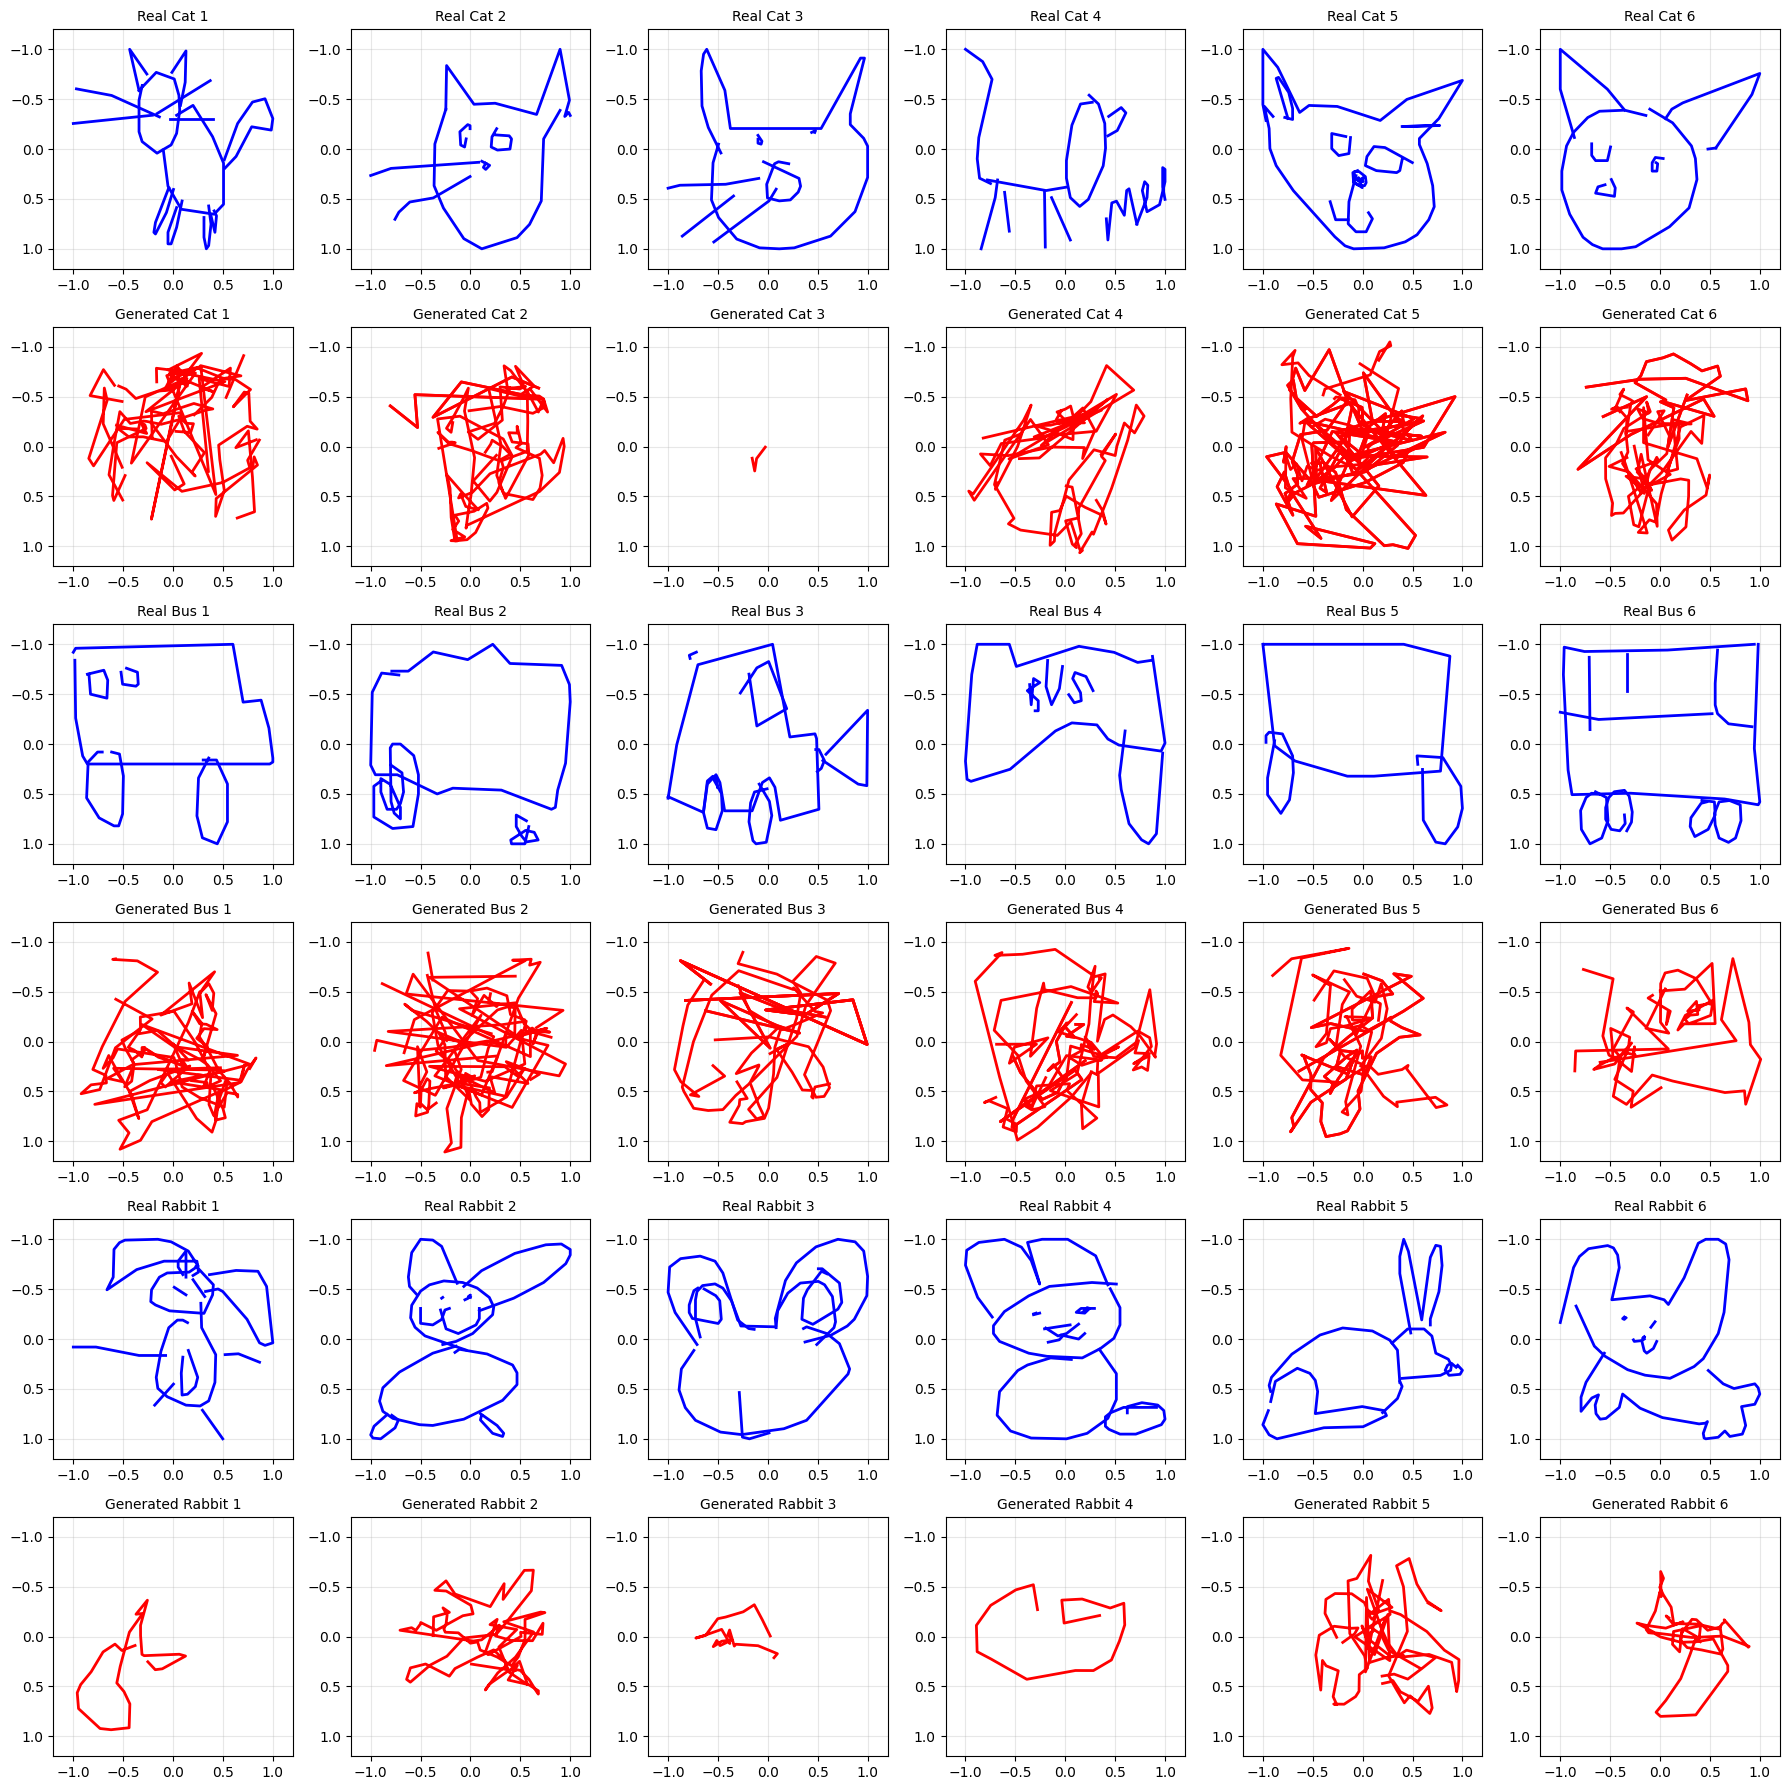

In [111]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))

for cat_idx, category in enumerate(['cat', 'bus', 'rabbit']):
    for i in range(6):
        # Real sketch
        real_seq = test_data[category][i]
        ax_real = axes[cat_idx*2, i]

        current_stroke = []
        pen_down = False

        for command, x, y in real_seq:
            if command >= 1.5:
                pen_down = True
                current_stroke = []
            elif -0.5 <= command <= 0.5 and pen_down:
                current_stroke.append([x.item(), y.item()])
            elif 0.5 <= command <= 1.5:
                if len(current_stroke) > 1:
                    xs, ys = zip(*current_stroke)
                    ax_real.plot(xs, ys, 'b-', linewidth=2)
                pen_down = False
            elif command >= 2.5:
                break

        ax_real.set_xlim(-1.2, 1.2)
        ax_real.set_ylim(-1.2, 1.2)
        ax_real.set_aspect('equal')
        ax_real.invert_yaxis()
        ax_real.set_title(f'Real {category.capitalize()} {i+1}', fontsize=10)
        ax_real.grid(True, alpha=0.3)

        # Generated sketch
        gen_seq = comparison_samples[category][i]
        ax_gen = axes[cat_idx*2+1, i]

        current_stroke = []
        pen_down = False

        for command, x, y in gen_seq:
            if command >= 1.5:
                pen_down = True
                current_stroke = []
            elif -0.5 <= command <= 0.5 and pen_down:
                current_stroke.append([x.item(), y.item()])
            elif 0.5 <= command <= 1.5:
                if len(current_stroke) > 1:
                    xs, ys = zip(*current_stroke)
                    ax_gen.plot(xs, ys, 'r-', linewidth=2)
                pen_down = False
            elif command >= 2.5:
                break

        ax_gen.set_xlim(-1.2, 1.2)
        ax_gen.set_ylim(-1.2, 1.2)
        ax_gen.set_aspect('equal')
        ax_gen.invert_yaxis()
        ax_gen.set_title(f'Generated {category.capitalize()} {i+1}', fontsize=10)
        ax_gen.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [112]:
# Analyze stroke counts in real vs generated
stroke_analysis = {}

for category in ['cat', 'bus', 'rabbit']:
    real_strokes = []
    gen_strokes = []

    # Count strokes in real data (sample 100)
    for seq in test_data[category][:100]:
        stroke_count = (seq[:, 0] == 2).sum().item()
        real_strokes.append(stroke_count)

    # Count strokes in generated data
    for seq in comparison_samples[category]:
        stroke_count = (seq[:, 0] >= 1.5).sum().item()
        gen_strokes.append(stroke_count)

    stroke_analysis[category] = {
        'real_mean': np.mean(real_strokes),
        'real_std': np.std(real_strokes),
        'gen_mean': np.mean(gen_strokes),
        'gen_std': np.std(gen_strokes)
    }

stroke_analysis

{'cat': {'real_mean': np.float64(9.72),
  'real_std': np.float64(3.441162594240499),
  'gen_mean': np.float64(7.166666666666667),
  'gen_std': np.float64(3.9756201472921875)},
 'bus': {'real_mean': np.float64(7.47),
  'real_std': np.float64(3.290759790686643),
  'gen_mean': np.float64(6.833333333333333),
  'gen_std': np.float64(1.6749792701868151)},
 'rabbit': {'real_mean': np.float64(8.06),
  'real_std': np.float64(3.830978987151979),
  'gen_mean': np.float64(4.166666666666667),
  'gen_std': np.float64(2.1921577396609844)}}

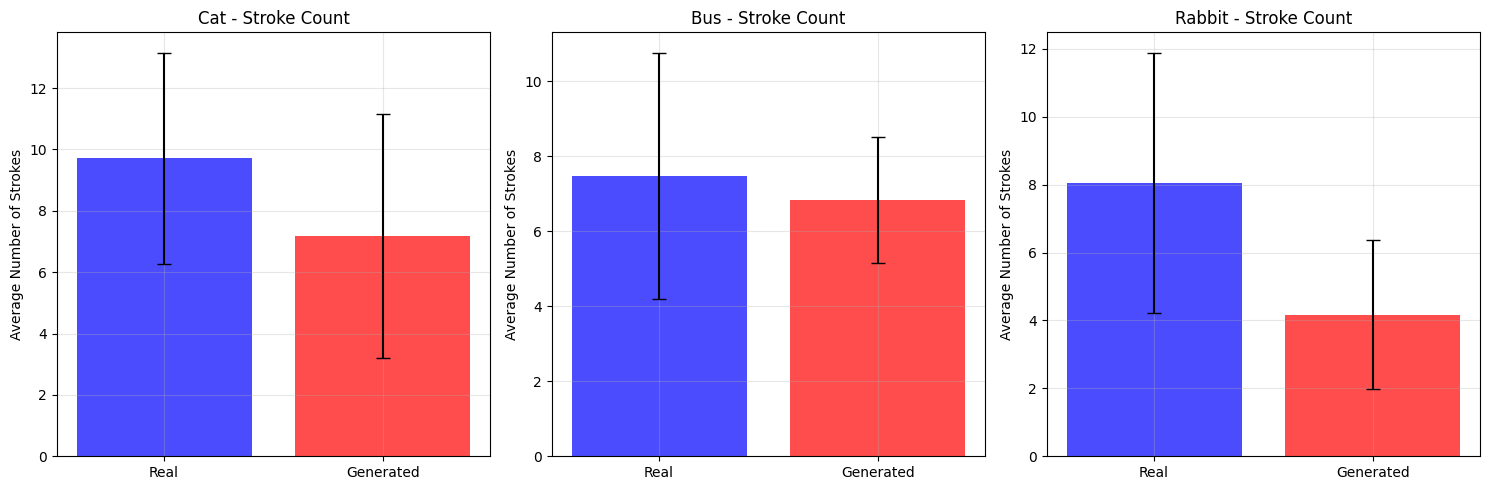

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, category in enumerate(['cat', 'bus', 'rabbit']):
    data = stroke_analysis[category]

    categories_plot = ['Real', 'Generated']
    means = [data['real_mean'], data['gen_mean']]
    stds = [data['real_std'], data['gen_std']]

    axes[i].bar(categories_plot, means, yerr=stds, capsize=5,
                color=['blue', 'red'], alpha=0.7)
    axes[i].set_title(f'{category.capitalize()} - Stroke Count')
    axes[i].set_ylabel('Average Number of Strokes')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [114]:
# Combine all performance metrics
performance_summary = {}

for category in ['cat', 'bus', 'rabbit']:
    fid = results[category]['FID']
    kid = results[category]['KID']
    dataset_size = len(all_data[category])

    # Get final training loss
    checkpoint = torch.load(f'./models/{category}_model.pth', map_location='cpu')
    final_loss = checkpoint['loss_history'][-1] if 'loss_history' in checkpoint else None

    performance_summary[category] = {
        'Dataset Size': dataset_size,
        'Final Loss': final_loss,
        'FID Score': fid,
        'KID Score': kid
    }

pd.DataFrame(performance_summary).T.round(4)

,Dataset Size,Final Loss,FID Score,KID Score
cat,10000.0,0.0310,383.0885,0.0215
bus,10000.0,0.0304,389.8269,0.0216
rabbit,10000.0,0.0301,354.9981,0.0214


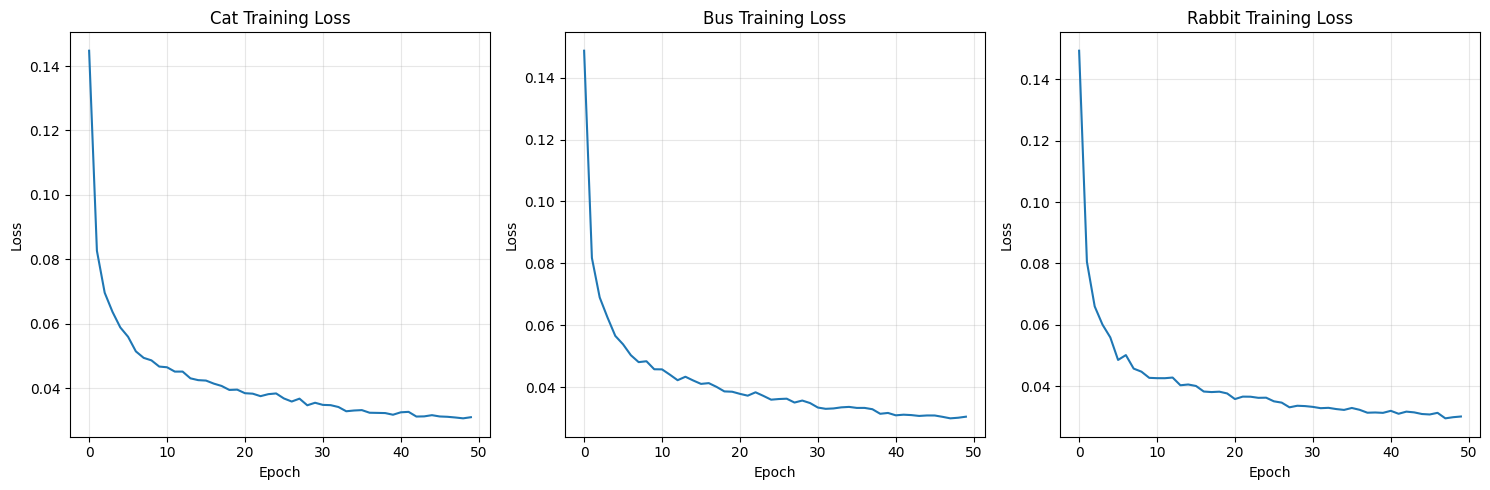

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, category in enumerate(['cat', 'bus', 'rabbit']):
    checkpoint = torch.load(f'./models/{category}_model.pth', map_location='cpu')
    if 'loss_history' in checkpoint:
        loss_history = checkpoint['loss_history']
        axes[i].plot(loss_history)
        axes[i].set_title(f'{category.capitalize()} Training Loss')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

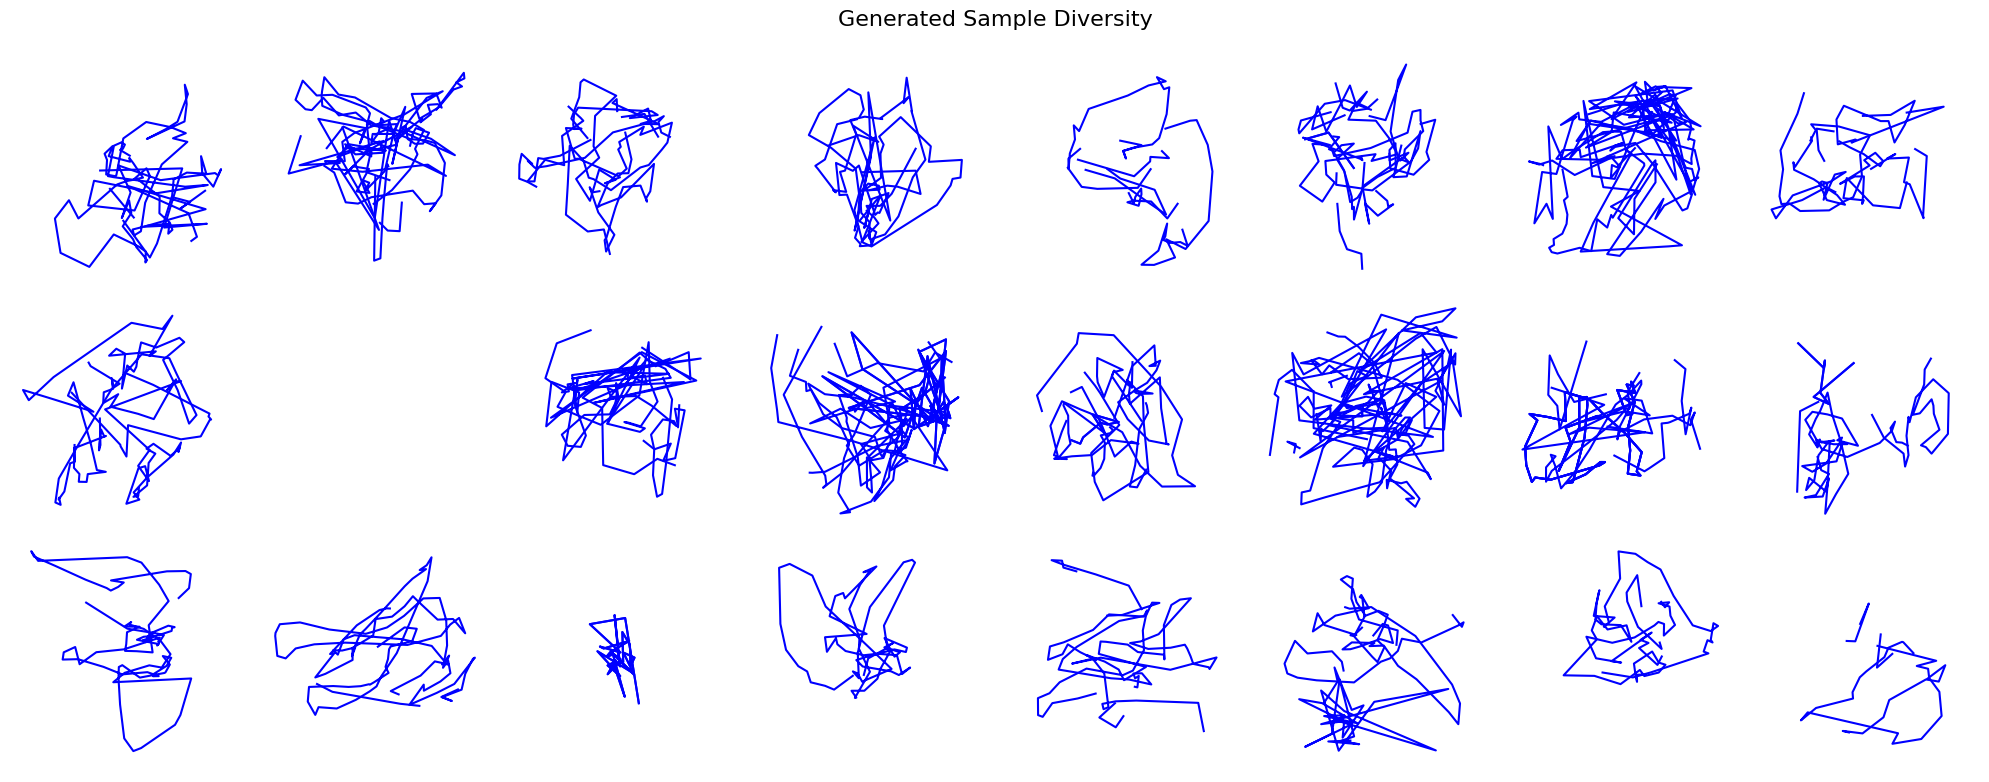

In [116]:
# Generate larger sample set for diversity assessment
fig, axes = plt.subplots(3, 8, figsize=(20, 8))

for cat_idx, category in enumerate(['cat', 'bus', 'rabbit']):
    for i in range(8):
        sample = generate_sample(models_list[category], noise_schedule)
        ax = axes[cat_idx, i]

        current_stroke = []
        pen_down = False

        for command, x, y in sample:
            if command >= 1.5:
                pen_down = True
                current_stroke = []
            elif -0.5 <= command <= 0.5 and pen_down:
                current_stroke.append([x.item(), y.item()])
            elif 0.5 <= command <= 1.5:
                if len(current_stroke) > 1:
                    xs, ys = zip(*current_stroke)
                    ax.plot(xs, ys, 'b-', linewidth=1.5)
                pen_down = False
            elif command >= 2.5:
                break

        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.axis('off')

        if i == 0:
            ax.set_ylabel(f'{category.capitalize()}', fontsize=14, fontweight='bold')

plt.suptitle('Generated Sample Diversity', fontsize=16)
plt.tight_layout()
plt.show()

In [117]:
# Display final FID and KID scores as required by assignment
final_results = pd.DataFrame(results).T
final_results.round(4)

,FID,KID
cat,383.0885,0.0215
bus,389.8269,0.0216
rabbit,354.9981,0.0214


# References

❗ Do not forget to include the references you used when filling out the notebook.

- [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
- [Teaching Machines to Draw](https://research.google/blog/teaching-machines-to-draw/)
- []()